---

# Retail Sales Forecast Using XGBoost

The goal of this project is to forecast the weekly sales from a particular retail department, given a dataset of 99 departments and 45 stores. 

I will be training the XGBoost algorithm locally first as a benchmark, and then recreating & deploying it on AWS Sagemaker to make use of AWS SageMaker's built-in Hyperparameter Tuning Job tool.

The phases of this project are as follows:
- Import Libraries & Datasets
- Data Cleaning
- Exploratory Data Analysis & Visualization
- Create Training & Testing Sets
- Train XGBoost Locally
- Train XGBoost in AWS SageMaker
- Deploy Model & Make Predictions
- Hyperparameter Optimization using AWS SageMaker
- Retrain & Deploy Model
- Conclusion

---

## Import Libraries & Datasets

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile

In [2]:
df_stores = pd.read_csv('stores_dataset.csv')
df_features = pd.read_csv('features_dataset.csv')
df_sales = pd.read_csv('sales_dataset.csv')

### df_stores

In [3]:
# Stores dataframe contains information related to the 45 stores, such as type and size of store. 
df_stores.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [4]:
df_stores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Store   45 non-null     int64 
 1   Type    45 non-null     object
 2   Size    45 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 1.2+ KB


In [5]:
df_stores.shape

(45, 3)

In [6]:
df_stores.describe()

,Store,Size
count,45.000000,45.000000
mean,23.000000,130287.600000
std,13.133926,63825.271991
min,1.000000,34875.000000
25%,12.000000,70713.000000
50%,23.000000,126512.000000
75%,34.000000,202307.000000
max,45.000000,219622.000000


In [7]:
df_stores.keys()

Index(['Store', 'Type', 'Size'], dtype='object')

### df_features

In [8]:
# Features dataframe contains data related to store, department, regional activity
# Store: store number
# Date: week
# Temperature: average temp in region
# Fuel_Price: cost of fuel in the region
# Markdown1-5: anonymized data related to promotional markdowns
# CPI: consumer price index
# Unemployment: UI rate
# IsHoliday: whether the week is a holiday or not

df_features

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,05/02/2010,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,12/02/2010,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,19/02/2010,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,26/02/2010,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,05/03/2010,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False
...,...,...,...,...,...,...,...,...,...,...,...,...
8185,45,28/06/2013,76.05,3.639,4842.29,975.03,3.00,2449.97,3169.69,NaN,NaN,False
8186,45,05/07/2013,77.50,3.614,9090.48,2268.58,582.74,5797.47,1514.93,NaN,NaN,False
8187,45,12/07/2013,79.37,3.614,3789.94,1827.31,85.72,744.84,2150.36,NaN,NaN,False
8188,45,19/07/2013,82.84,3.737,2961.49,1047.07,204.19,363.00,1059.46,NaN,NaN,False


In [9]:
df_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8190 entries, 0 to 8189
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         8190 non-null   int64  
 1   Date          8190 non-null   object 
 2   Temperature   8190 non-null   float64
 3   Fuel_Price    8190 non-null   float64
 4   MarkDown1     4032 non-null   float64
 5   MarkDown2     2921 non-null   float64
 6   MarkDown3     3613 non-null   float64
 7   MarkDown4     3464 non-null   float64
 8   MarkDown5     4050 non-null   float64
 9   CPI           7605 non-null   float64
 10  Unemployment  7605 non-null   float64
 11  IsHoliday     8190 non-null   bool   
dtypes: bool(1), float64(9), int64(1), object(1)
memory usage: 712.0+ KB


In [10]:
df_features.shape

(8190, 12)

In [11]:
df_features.describe()

,Store,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
count,8190.000000,8190.000000,8190.000000,4032.000000,2921.000000,3613.000000,3464.000000,4050.000000,7605.000000,7605.000000
mean,23.000000,59.356198,3.405992,7032.371786,3384.176594,1760.100180,3292.935886,4132.216422,172.460809,7.826821
std,12.987966,18.678607,0.431337,9262.747448,8793.583016,11276.462208,6792.329861,13086.690278,39.738346,1.877259
min,1.000000,-7.290000,2.472000,-2781.450000,-265.760000,-179.260000,0.220000,-185.170000,126.064000,3.684000
25%,12.000000,45.902500,3.041000,1577.532500,68.880000,6.600000,304.687500,1440.827500,132.364839,6.634000
50%,23.000000,60.710000,3.513000,4743.580000,364.570000,36.260000,1176.425000,2727.135000,182.764003,7.806000
75%,34.000000,73.880000,3.743000,8923.310000,2153.350000,163.150000,3310.007500,4832.555000,213.932412,8.567000
max,45.000000,101.950000,4.468000,103184.980000,104519.540000,149483.310000,67474.850000,771448.100000,228.976456,14.313000


In [12]:
df_features.keys()

Index(['Store', 'Date', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2',
       'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment',
       'IsHoliday'],
      dtype='object')

### df_sales

In [13]:
# Sales dataframe contains historical sales data, covering 2010-02-05 to 2012-11-01
# Store: store number
# Dept: department number
# Date: the week
# Weekly_Sales: sales for given department in given store
# IsHoliday: whether the week is a holiday or not

df_sales

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,05/02/2010,24924.50,False
1,1,1,12/02/2010,46039.49,True
2,1,1,19/02/2010,41595.55,False
3,1,1,26/02/2010,19403.54,False
4,1,1,05/03/2010,21827.90,False
...,...,...,...,...,...
421565,45,98,28/09/2012,508.37,False
421566,45,98,05/10/2012,628.10,False
421567,45,98,12/10/2012,1061.02,False
421568,45,98,19/10/2012,760.01,False


In [14]:
df_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
dtypes: bool(1), float64(1), int64(2), object(1)
memory usage: 13.3+ MB


In [15]:
df_sales.shape

(421570, 5)

In [16]:
df_sales.describe()

,Store,Dept,Weekly_Sales
count,421570.000000,421570.000000,421570.000000
mean,22.200546,44.260317,15981.258123
std,12.785297,30.492054,22711.183519
min,1.000000,1.000000,-4988.940000
25%,11.000000,18.000000,2079.650000
50%,22.000000,37.000000,7612.030000
75%,33.000000,74.000000,20205.852500
max,45.000000,99.000000,693099.360000


In [17]:
df_sales.keys()

Index(['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday'], dtype='object')

---

## Data Cleaning

Change datatypes of date columns

In [18]:
df_features['Date'] = pd.to_datetime(df_features['Date'])
df_sales['Date'] = pd.to_datetime(df_sales['Date'])

Merge dataset into one dataframe

In [19]:
df_sales.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-05-02,24924.50,False
1,1,1,2010-12-02,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-05-03,21827.90,False


In [20]:
df_features.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-05-02,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-12-02,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-05-03,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [21]:
df = pd.merge(df_sales, df_features, on = ['Store', 'Date', 'IsHoliday'], how = 'left')

In [22]:
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
0,1,1,2010-05-02,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
1,1,1,2010-12-02,46039.49,True,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106
2,1,1,2010-02-19,41595.55,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106
3,1,1,2010-02-26,19403.54,False,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106
4,1,1,2010-05-03,21827.90,False,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106


In [23]:
df_stores.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [24]:
df = pd.merge(df, df_stores, on = ['Store'], how = 'left')

In [25]:
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2010-05-02,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
1,1,1,2010-12-02,46039.49,True,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,A,151315
2,1,1,2010-02-19,41595.55,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,A,151315
3,1,1,2010-02-26,19403.54,False,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,A,151315
4,1,1,2010-05-03,21827.90,False,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,A,151315


Split date

In [26]:
def get_month(i):
    return int(str(i).split('-')[1])

In [27]:
df['Month'] = df['Date'].apply(get_month)

In [28]:
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,Month
0,1,1,2010-05-02,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315,5
1,1,1,2010-12-02,46039.49,True,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,A,151315,12
2,1,1,2010-02-19,41595.55,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,A,151315,2
3,1,1,2010-02-26,19403.54,False,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,A,151315,2
4,1,1,2010-05-03,21827.90,False,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,A,151315,5


Check for null elements

<AxesSubplot:>

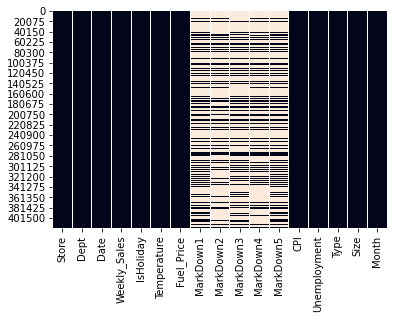

In [29]:
sns.heatmap(df.isnull(), cbar = False)

In [30]:
df.isnull().sum()

Store                0
Dept                 0
Date                 0
Weekly_Sales         0
IsHoliday            0
Temperature          0
Fuel_Price           0
MarkDown1       270889
MarkDown2       310322
MarkDown3       284479
MarkDown4       286603
MarkDown5       270138
CPI                  0
Unemployment         0
Type                 0
Size                 0
Month                0
dtype: int64

Change null elements to 0

In [31]:
df = df.fillna(0)

In [32]:
df

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,Month
0,1,1,2010-05-02,24924.50,False,42.31,2.572,0.00,0.00,0.00,0.00,0.00,211.096358,8.106,A,151315,5
1,1,1,2010-12-02,46039.49,True,38.51,2.548,0.00,0.00,0.00,0.00,0.00,211.242170,8.106,A,151315,12
2,1,1,2010-02-19,41595.55,False,39.93,2.514,0.00,0.00,0.00,0.00,0.00,211.289143,8.106,A,151315,2
3,1,1,2010-02-26,19403.54,False,46.63,2.561,0.00,0.00,0.00,0.00,0.00,211.319643,8.106,A,151315,2
4,1,1,2010-05-03,21827.90,False,46.50,2.625,0.00,0.00,0.00,0.00,0.00,211.350143,8.106,A,151315,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421565,45,98,2012-09-28,508.37,False,64.88,3.997,4556.61,20.64,1.50,1601.01,3288.25,192.013558,8.684,B,118221,9
421566,45,98,2012-05-10,628.10,False,64.89,3.985,5046.74,0.00,18.82,2253.43,2340.01,192.170412,8.667,B,118221,5
421567,45,98,2012-12-10,1061.02,False,54.47,4.000,1956.28,0.00,7.89,599.32,3990.54,192.327265,8.667,B,118221,12
421568,45,98,2012-10-19,760.01,False,56.47,3.969,2004.02,0.00,3.18,437.73,1537.49,192.330854,8.667,B,118221,10


In [33]:
df.describe()

,Store,Dept,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Size,Month
count,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000
mean,22.200546,44.260317,15981.258123,60.090059,3.361027,2590.074819,879.974298,468.087665,1083.132268,1662.772385,171.201947,7.960289,136727.915739,6.478580
std,12.785297,30.492054,22711.183519,18.447931,0.458515,6052.385934,5084.538801,5528.873453,3894.529945,4207.629321,39.159276,1.863296,60980.583328,3.324757
min,1.000000,1.000000,-4988.940000,-2.060000,2.472000,0.000000,-265.760000,-29.100000,0.000000,0.000000,126.064000,3.879000,34875.000000,1.000000
25%,11.000000,18.000000,2079.650000,46.680000,2.933000,0.000000,0.000000,0.000000,0.000000,0.000000,132.022667,6.891000,93638.000000,4.000000
50%,22.000000,37.000000,7612.030000,62.090000,3.452000,0.000000,0.000000,0.000000,0.000000,0.000000,182.318780,7.866000,140167.000000,6.000000
75%,33.000000,74.000000,20205.852500,74.280000,3.738000,2809.050000,2.200000,4.540000,425.290000,2168.040000,212.416993,8.572000,202505.000000,9.000000
max,45.000000,99.000000,693099.360000,100.140000,4.468000,88646.760000,104519.540000,141630.610000,67474.850000,108519.280000,227.232807,14.313000,219622.000000,12.000000


Check for duplicated entries in dataframe

In [34]:
df.duplicated().sum()

0

In [35]:
df.IsHoliday

0         False
1          True
2         False
3         False
4         False
          ...  
421565    False
421566    False
421567    False
421568    False
421569    False
Name: IsHoliday, Length: 421570, dtype: bool

Change IsHoliday to 1 / 0

In [40]:
df['IsHoliday'] = df['IsHoliday'].replace(to_replace=[True, False], value=[1,0])

In [44]:
df['IsHoliday'].head()

0    0
1    1
2    0
3    0
4    0
Name: IsHoliday, dtype: int64

---

## Exploratory Data Analysis & Visualization

In [45]:
result = pd.pivot_table(df, values = 'Weekly_Sales', columns = ['Type'], index = ['Date', 'Store', 'Dept'],
                       aggfunc=np.mean)

In [46]:
result

Type                          A         B   C
Date       Store Dept                        
2010-01-10 1     1     20094.19       NaN NaN
                 2     45829.02       NaN NaN
                 3      9775.17       NaN NaN
                 4     34912.45       NaN NaN
                 5     23381.38       NaN NaN
...                         ...       ...  ..
2012-12-10 45    93         NaN   2644.24 NaN
                 94         NaN   4041.28 NaN
                 95         NaN  49334.77 NaN
                 97         NaN   6463.32 NaN
                 98         NaN   1061.02 NaN

[421570 rows x 3 columns]

Type A stores have much higher sales:

In [47]:
result.describe()

Type,A,B,C
count,215478.000000,163495.000000,42597.000000
mean,20099.568043,12237.075977,9519.532538
std,26423.457227,17203.668989,15985.351612
min,-4988.940000,-3924.000000,-379.000000
25%,3315.090000,1927.055000,131.990000
50%,10105.170000,6187.870000,1149.670000
75%,26357.180000,15353.740000,12695.010000
max,474330.100000,693099.360000,112152.350000


### Impact of Markdowns

In [49]:
result_md = pd.pivot_table(df, values = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5'], columns = ['IsHoliday'], index = ['Date', 'Store', 'Dept'],
                          aggfunc={'MarkDown1': np.mean, 'MarkDown2': np.mean, 'MarkDown3': np.mean, 'MarkDown4': np.mean, 'MarkDown5': np.mean})

MarkDown1     MarkDown2     MarkDown3     MarkDown4      \
IsHoliday                     0   1         0   1         0   1         0   1   
Date       Store Dept                                                           
2010-01-10 1     1         0.00 NaN       0.0 NaN      0.00 NaN      0.00 NaN   
                 2         0.00 NaN       0.0 NaN      0.00 NaN      0.00 NaN   
                 3         0.00 NaN       0.0 NaN      0.00 NaN      0.00 NaN   
                 4         0.00 NaN       0.0 NaN      0.00 NaN      0.00 NaN   
                 5         0.00 NaN       0.0 NaN      0.00 NaN      0.00 NaN   
...                         ...  ..       ...  ..       ...  ..       ...  ..   
2012-12-10 45    93     1956.28 NaN       0.0 NaN      7.89 NaN    599.32 NaN   
                 94     1956.28 NaN       0.0 NaN      7.89 NaN    599.32 NaN   
                 95     1956.28 NaN       0.0 NaN      7.89 NaN    599.32 NaN   
                 97     1956.28 NaN       0.0 NaN      7.89 NaN    599.32 NaN   
                 98     1956.28 NaN       0.0 NaN      7.89 NaN    599.32 NaN   

                      MarkDown5      
IsHoliday                     0   1  
Date       Store Dept                
2010-01-10 1     1         0.00 NaN  
                 2         0.00 NaN  
                 3         0.00 NaN  
                 4         0.00 NaN  
                 5         0.00 NaN  
...                         ...  ..  
2012-12-10 45    93     3990.54 NaN  
                 94     3990.54 NaN  
                 95     3990.54 NaN  
                 97     3990.54 NaN  
                 98     3990.54 NaN  

[421570 rows x 10 columns]

It appears that MarkDown2 and MarkDown3 have higher volume on holidays compared to that of regular days. Other MarkDowns don't seem to show significant changes on holidays:

In [51]:
result_md.describe()

MarkDown1                    MarkDown2                 \
IsHoliday              0             1              0              1   
count      391909.000000  29661.000000  391909.000000   29661.000000   
mean         2595.936803   2512.620778     589.580546    4716.929394   
std          6123.402037   5020.047408    2984.163111   15295.329993   
min             0.000000      0.000000    -265.760000      -9.980000   
25%             0.000000      0.000000       0.000000       0.000000   
50%             0.000000      0.000000       0.000000       0.000000   
75%          2826.570000   2463.160000       0.500000      65.000000   
max         88646.760000  36778.650000   45971.430000  104519.540000   

               MarkDown3                     MarkDown4                \
IsHoliday              0              1              0             1   
count      391909.000000   29661.000000  391909.000000  29661.000000   
mean           62.778142    5823.417900    1070.741151   1246.855336   
std           630.704594   19959.302249    3921.553070   3513.998030   
min           -29.100000       0.000000       0.000000      0.000000   
25%             0.000000       0.000000       0.000000      0.000000   
50%             0.000000       0.000000       0.000000      0.000000   
75%             3.840000      66.080000     442.390000    319.190000   
max         25959.980000  141630.610000   67474.850000  29483.810000   

               MarkDown5                
IsHoliday              0             1  
count      391909.000000  29661.000000  
mean         1680.408001   1429.754053  
std          4312.031598   2427.638027  
min             0.000000      0.000000  
25%             0.000000      0.000000  
50%             0.000000      0.000000  
75%          2182.320000   2069.300000  
max        108519.280000  11100.550000

### Correlations

In [52]:
# Dropping Store
corr_matrix = df.drop(columns = ['Store']).corr()

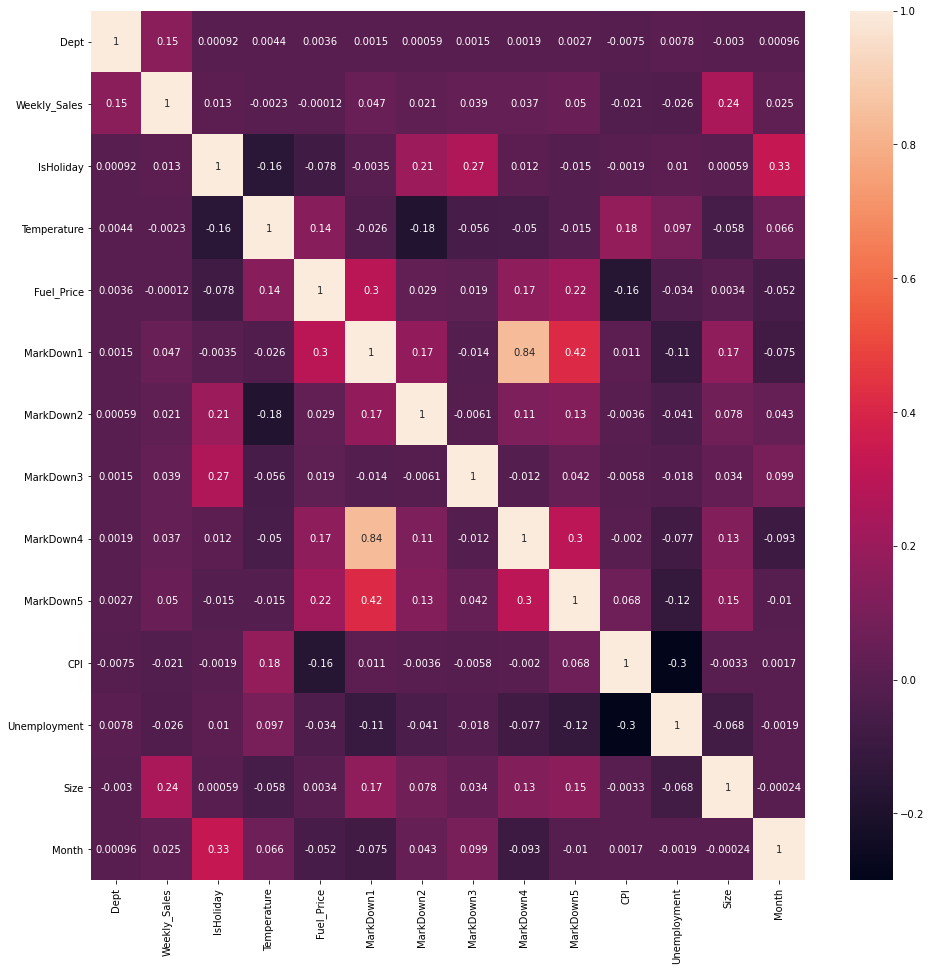

In [53]:
plt.figure(figsize = (16, 16))
sns.heatmap(corr_matrix, annot = True)
plt.show()

### Histogram

array([[<AxesSubplot:title={'center':'Store'}>,
        <AxesSubplot:title={'center':'Dept'}>,
        <AxesSubplot:title={'center':'Weekly_Sales'}>,
        <AxesSubplot:title={'center':'IsHoliday'}>],
       [<AxesSubplot:title={'center':'Temperature'}>,
        <AxesSubplot:title={'center':'Fuel_Price'}>,
        <AxesSubplot:title={'center':'MarkDown1'}>,
        <AxesSubplot:title={'center':'MarkDown2'}>],
       [<AxesSubplot:title={'center':'MarkDown3'}>,
        <AxesSubplot:title={'center':'MarkDown4'}>,
        <AxesSubplot:title={'center':'MarkDown5'}>,
        <AxesSubplot:title={'center':'CPI'}>],
       [<AxesSubplot:title={'center':'Unemployment'}>,
        <AxesSubplot:title={'center':'Size'}>,
        <AxesSubplot:title={'center':'Month'}>, <AxesSubplot:>]],
      dtype=object)

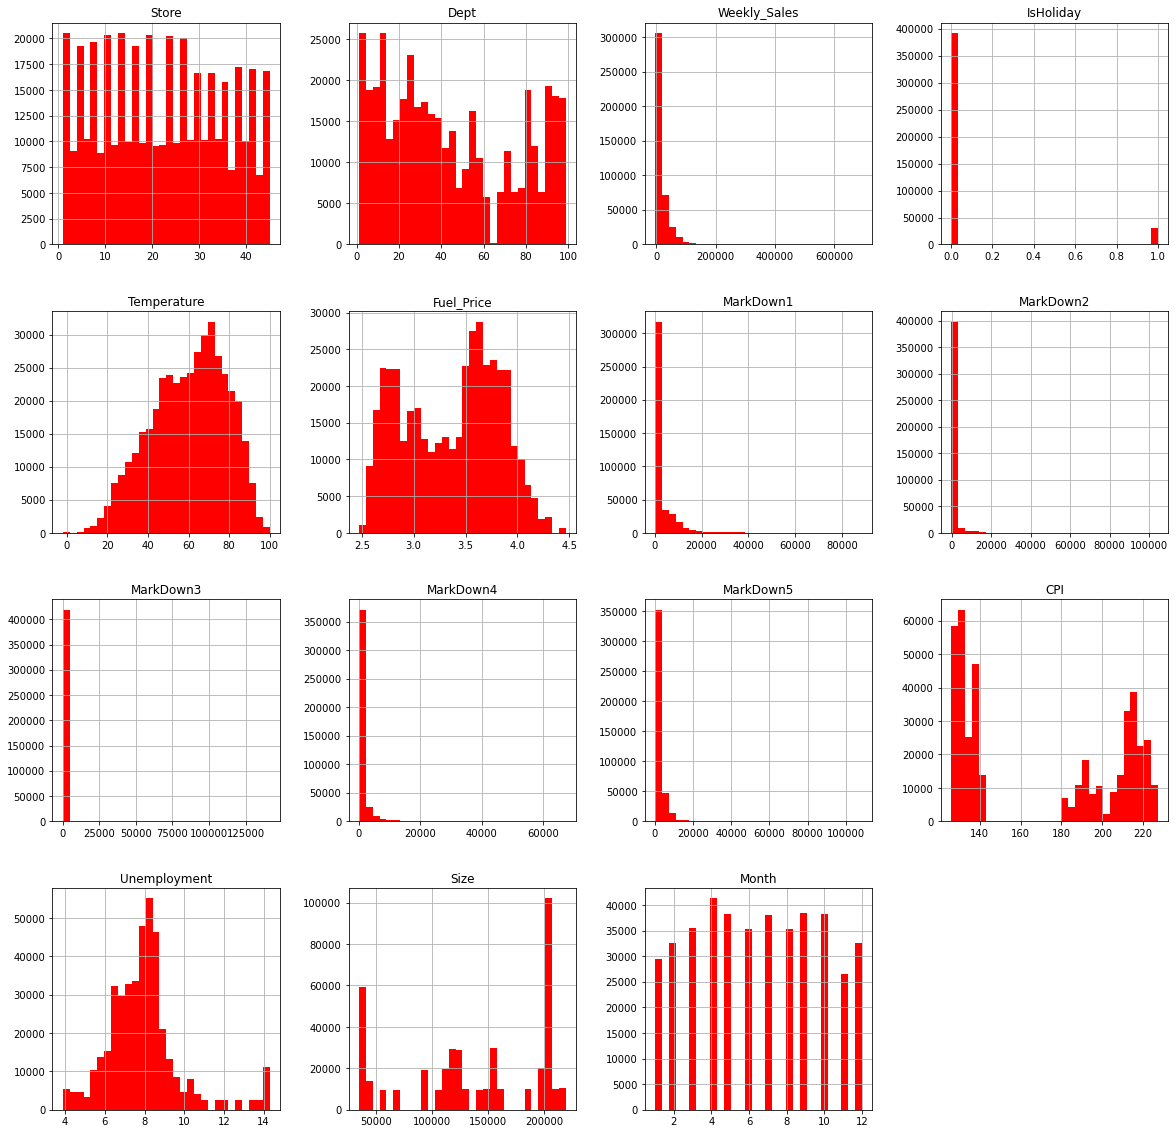

In [54]:
df.hist(bins = 30, figsize = (20, 20), color = 'r')

### Pairplot

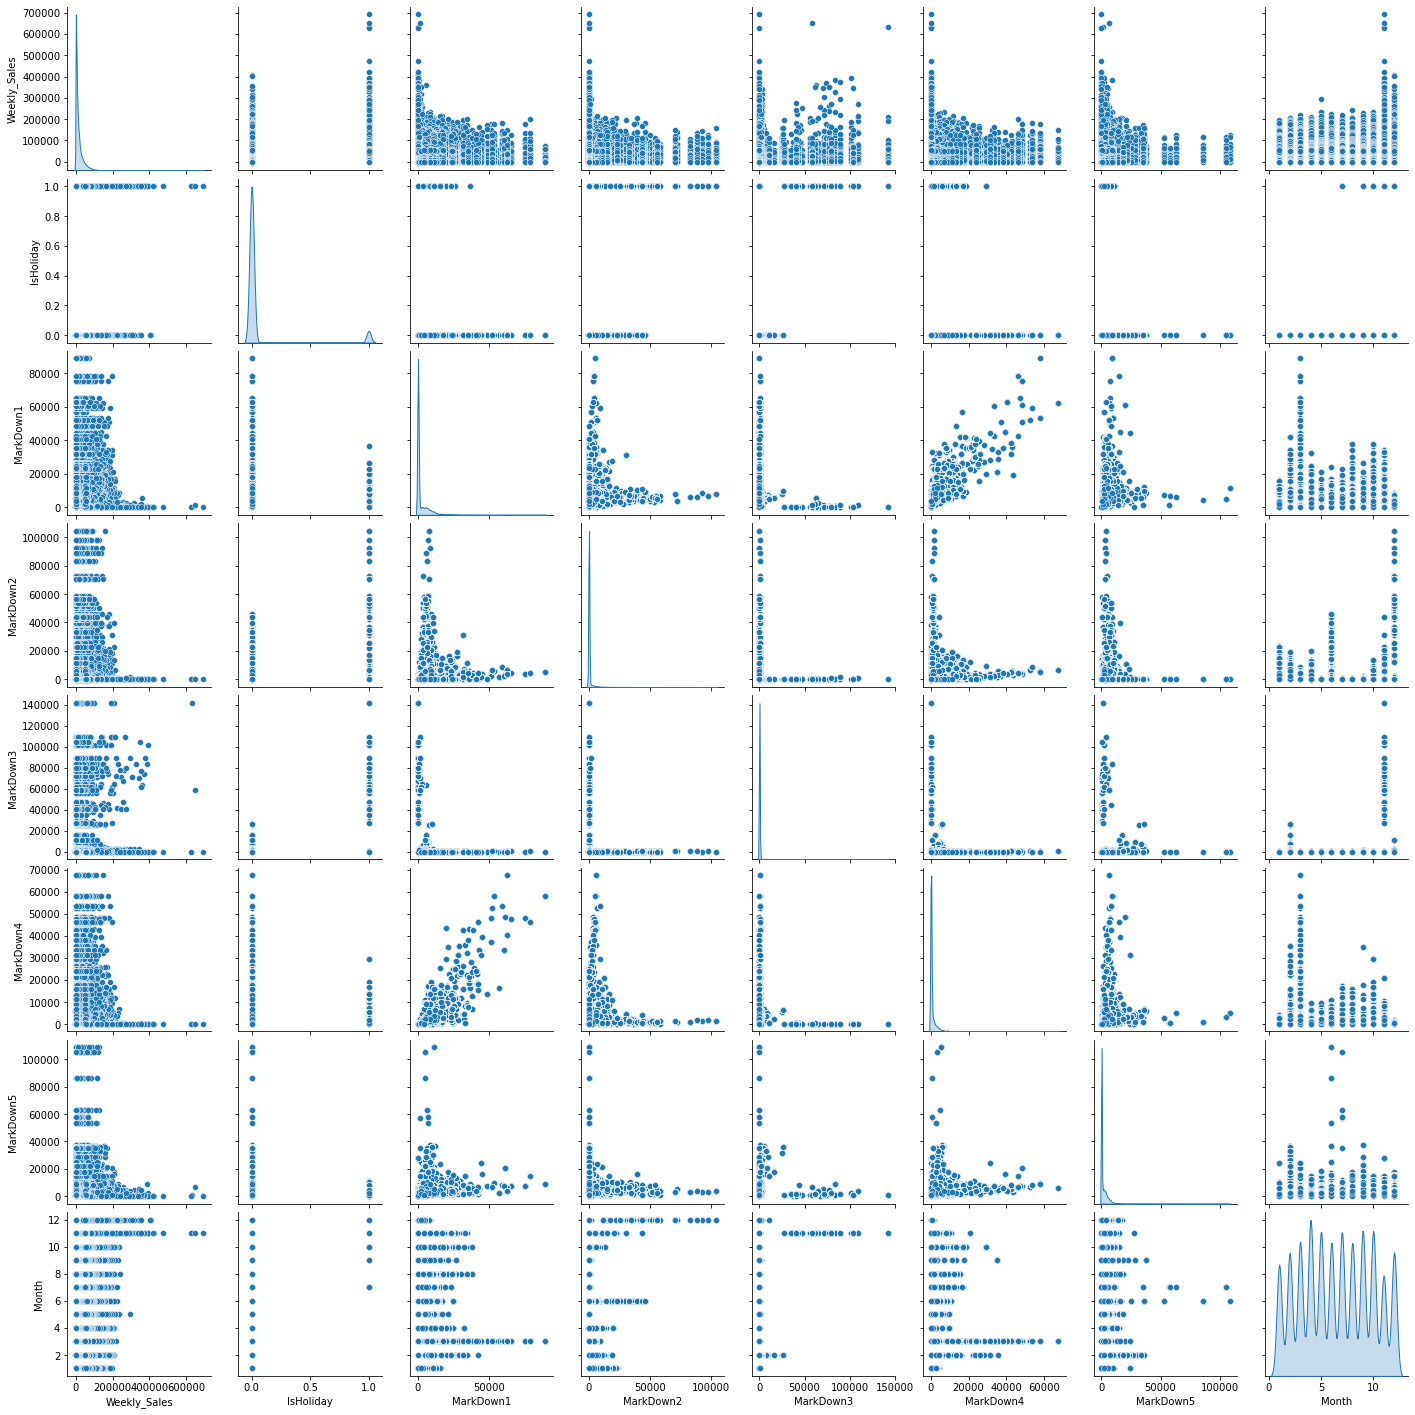

In [56]:
sns.pairplot(df[['Weekly_Sales', 'IsHoliday', 'MarkDown1', 'MarkDown2', 'MarkDown3', \
                 'MarkDown4', 'MarkDown5', 'Type', 'Month']], diag_kind = 'kde')

### Exploring the difference in Type of store

In [61]:
df_type = df.groupby('Type').mean()
df_type

,Store,Dept,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Size,Month
Type,,,,,,,,,,,,,,,
A,21.736419,44.622156,20099.568043,0.070471,60.531945,3.343999,3102.403194,1083.216159,549.644930,1325.891281,2147.830168,174.408895,7.791595,182231.285486,6.480030
B,18.450417,43.112273,12237.075977,0.070412,57.562951,3.382523,2553.465968,827.500452,481.215226,1043.927675,1324.921913,167.176656,7.928836,101818.735827,6.478100
C,38.942015,46.836350,9519.532538,0.069582,67.554266,3.364654,138.960203,53.274338,5.142226,5.603993,505.826631,170.429314,8.934350,40535.725286,6.473085


<AxesSubplot:xlabel='Type', ylabel='Weekly_Sales'>

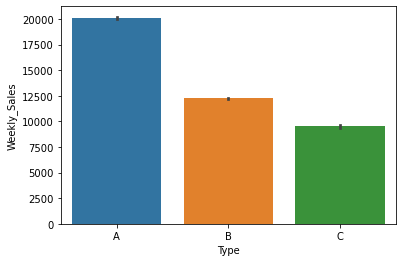

In [59]:
sns.barplot(x = df['Type'], y = df['Weekly_Sales'], data = df)

### Difference in Departments

In [60]:
df_dept = df.groupby('Dept').mean()
df_dept

,Store,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Size,Month
Dept,,,,,,,,,,,,,,
1,23.000000,19213.485088,0.069930,60.663782,3.358607,2429.019322,818.872810,429.184037,1008.870435,1581.806813,171.578394,7.999151,130287.600000,6.475524
2,23.000000,43607.020113,0.069930,60.663782,3.358607,2429.019322,818.872810,429.184037,1008.870435,1581.806813,171.578394,7.999151,130287.600000,6.475524
3,23.000000,11793.698516,0.069930,60.663782,3.358607,2429.019322,818.872810,429.184037,1008.870435,1581.806813,171.578394,7.999151,130287.600000,6.475524
4,23.000000,25974.630238,0.069930,60.663782,3.358607,2429.019322,818.872810,429.184037,1008.870435,1581.806813,171.578394,7.999151,130287.600000,6.475524
5,22.757366,21365.583515,0.069797,60.559367,3.365397,2462.697233,830.226332,435.134596,1022.858240,1603.738276,171.109374,7.978057,131530.357964,6.479439
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,23.000000,69824.423080,0.069930,60.663782,3.358607,2429.019322,818.872810,429.184037,1008.870435,1581.806813,171.578394,7.999151,130287.600000,6.475524
96,23.258138,15210.942761,0.069839,61.539285,3.359920,2362.845647,820.762363,397.214137,999.452087,1660.599345,171.562686,7.849295,129282.010507,6.482489
97,23.357439,14255.576919,0.069767,60.490781,3.362418,2463.638764,833.096524,432.439341,1025.957821,1591.276367,170.445933,8.043564,130676.377190,6.477700


<AxesSubplot:ylabel='Dept'>

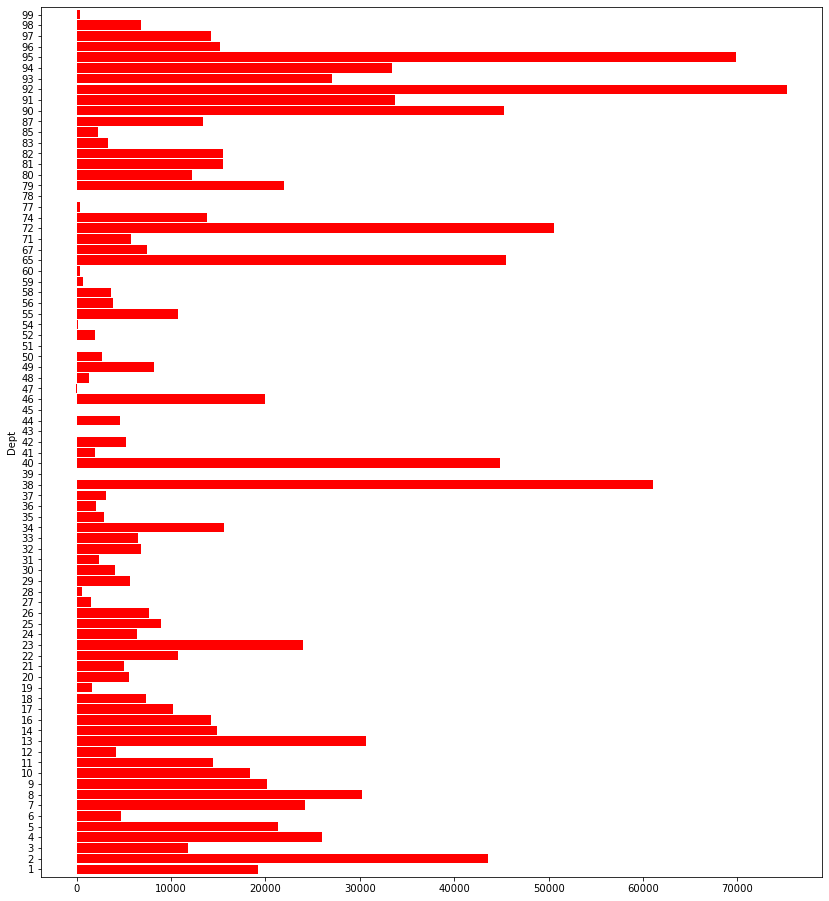

In [62]:
fig = plt.figure(figsize = (14,16))
df_dept['Weekly_Sales'].plot(kind = 'barh', color = 'r', width = 0.9)

<AxesSubplot:ylabel='Dept'>

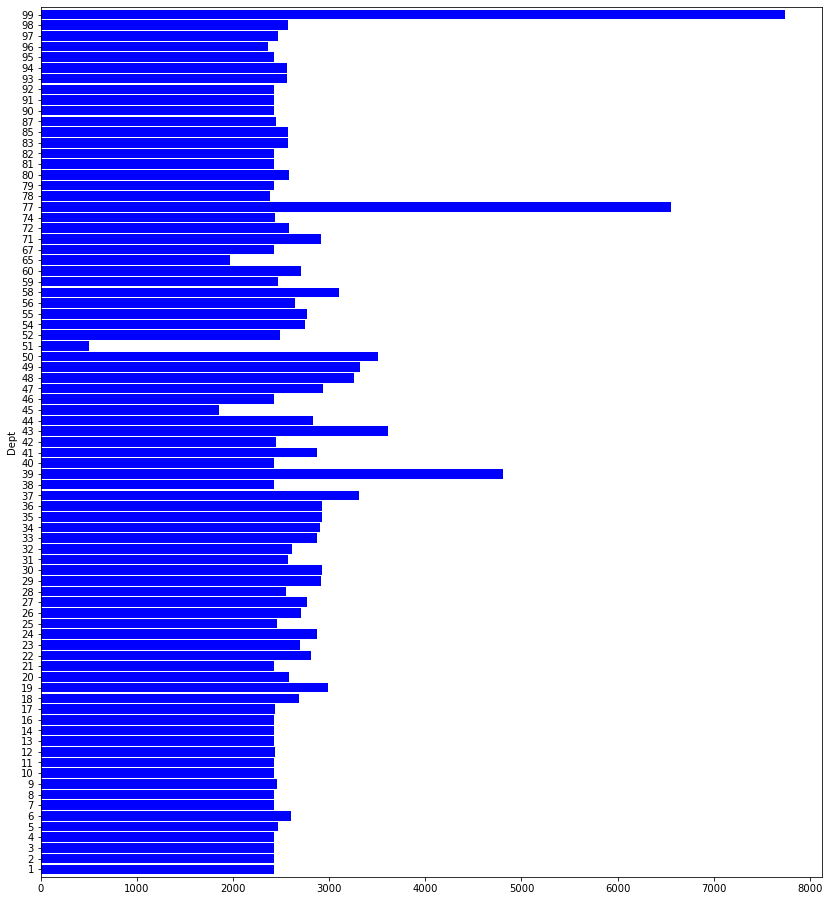

In [63]:
fig = plt.figure(figsize = (14,16))
df_dept['MarkDown1'].plot(kind = 'barh', color = 'blue', width = 0.9)

<AxesSubplot:ylabel='Dept'>

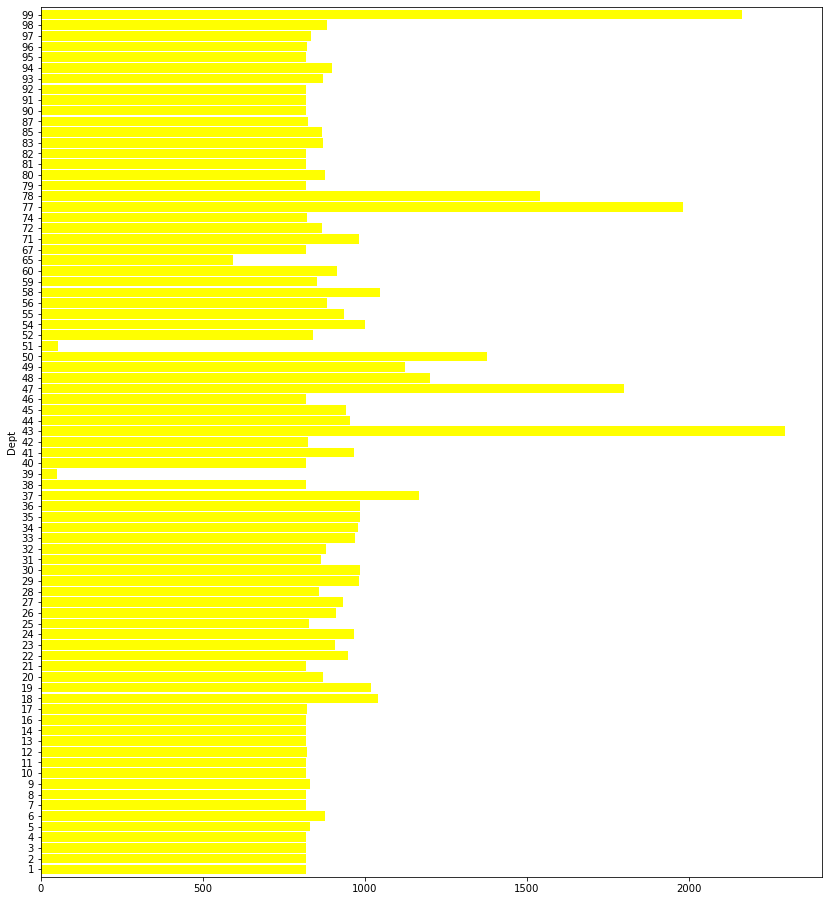

In [64]:
fig = plt.figure(figsize = (14,16))
df_dept['MarkDown2'].plot(kind = 'barh', color = 'yellow', width = 0.9)

<AxesSubplot:ylabel='Dept'>

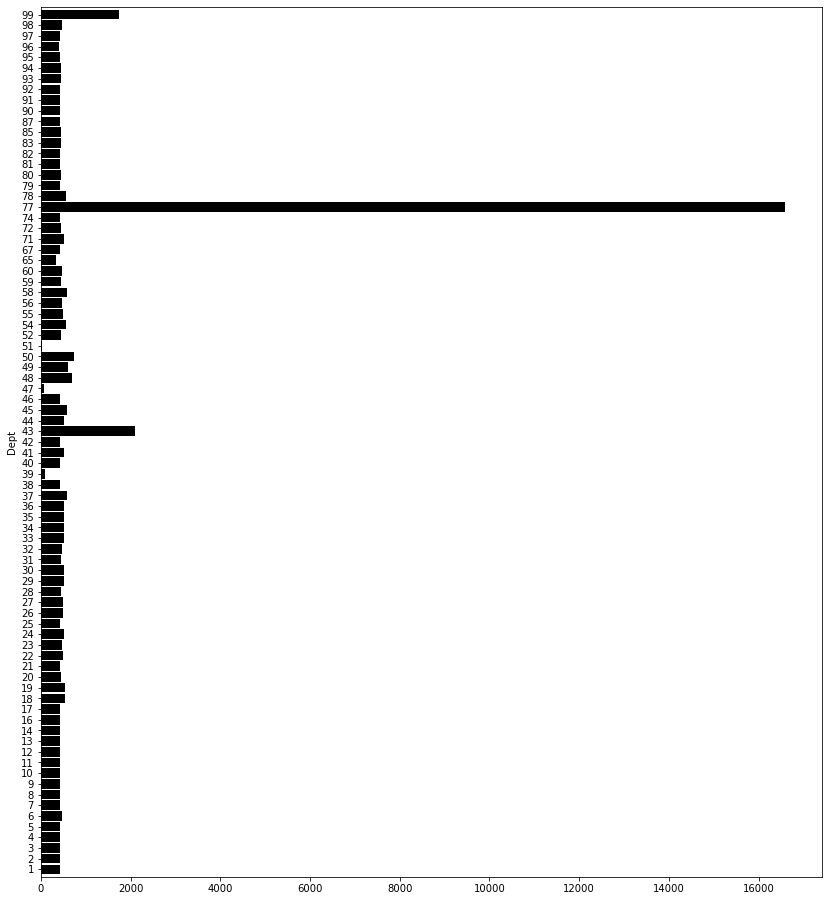

In [65]:
fig = plt.figure(figsize = (14,16))
df_dept['MarkDown3'].plot(kind = 'barh', color = 'black', width = 0.9)

<AxesSubplot:ylabel='Dept'>

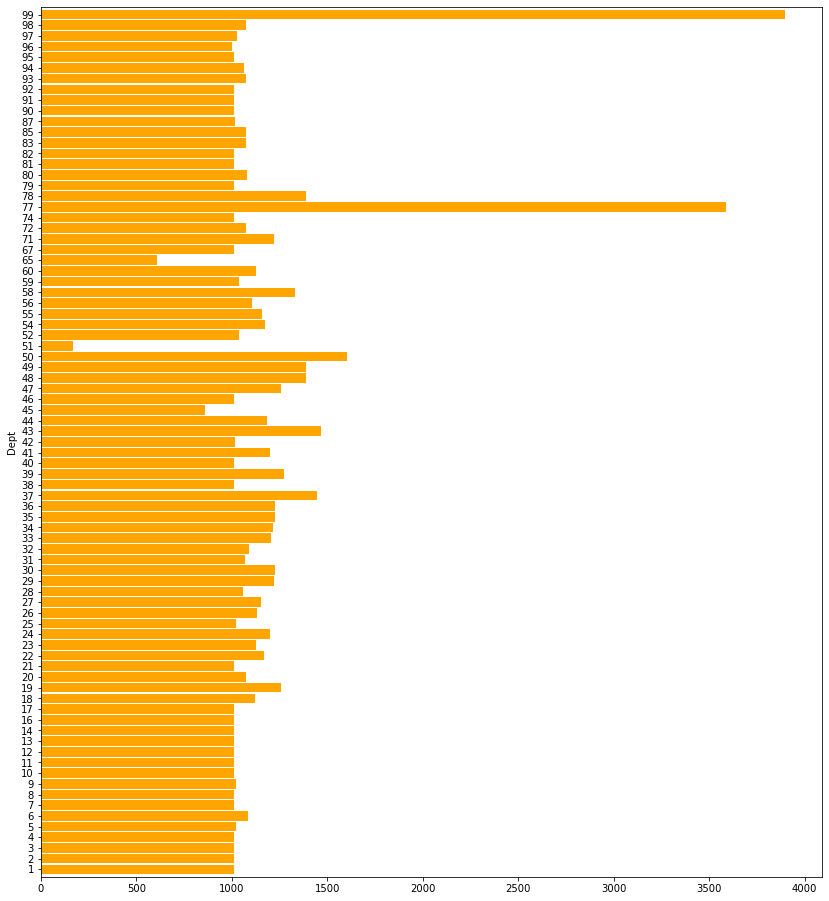

In [66]:
fig = plt.figure(figsize = (14,16))
df_dept['MarkDown4'].plot(kind = 'barh', color = 'orange', width = 0.9)

<AxesSubplot:ylabel='Dept'>

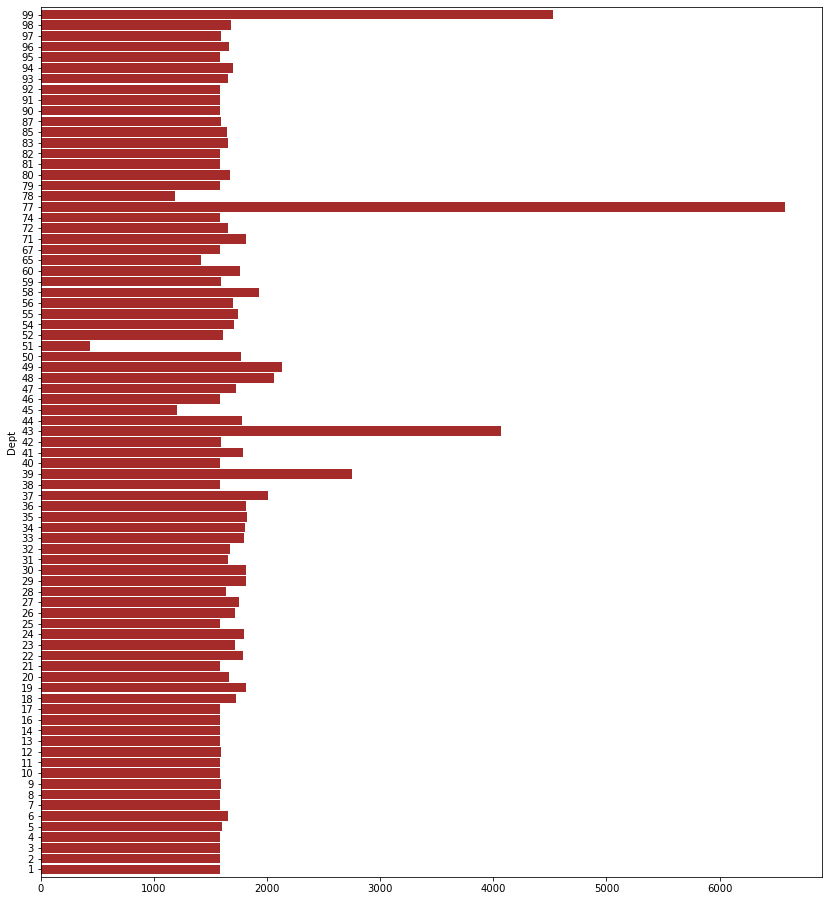

In [67]:
fig = plt.figure(figsize = (14,16))
df_dept['MarkDown5'].plot(kind = 'barh', color = 'brown', width = 0.9)

It appears that the departments which have poor weekly sales also tend to have a high number of markdowns (example: store 77 and 99)

Sort by weekly sales:

In [68]:
df_dept_sale = df_dept.sort_values(by = ['Weekly_Sales'], ascending = True)
df_dept_sale['Weekly_Sales'][:30]

Dept
47      -7.682554
43       1.193333
78       7.296638
39      11.123750
51      21.931729
45      23.211586
54     108.305985
77     328.961800
60     347.370229
99     415.487065
28     618.085116
59     694.463564
48    1344.893576
27    1583.437727
19    1654.815030
52    1928.356252
41    1965.559998
36    2022.571061
85    2264.359407
31    2339.440287
50    2658.897010
35    2921.044946
37    3111.076193
83    3383.349838
58    3702.907419
56    3833.706211
30    4118.197208
12    4175.397021
44    4651.729658
6     4747.856188
Name: Weekly_Sales, dtype: float64

---

## Create Training & Testing Sets

Drop Date

In [70]:
df_target = df['Weekly_Sales']
df_final = df.drop(columns = ['Weekly_Sales', 'Date'])

Dummy Variables - drop_first = True to avoid dummy variable trap

In [71]:
df_final = pd.get_dummies(df_final, columns = ['Type', 'Store', 'Dept'], drop_first = True)

In [76]:
df_final.shape

(421570, 138)

In [74]:
df_target.shape

(421570,)

In [77]:
df_final

,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,...,Dept_90,Dept_91,Dept_92,Dept_93,Dept_94,Dept_95,Dept_96,Dept_97,Dept_98,Dept_99
0,0,42.31,2.572,0.00,0.00,0.00,0.00,0.00,211.096358,8.106,...,0,0,0,0,0,0,0,0,0,0
1,1,38.51,2.548,0.00,0.00,0.00,0.00,0.00,211.242170,8.106,...,0,0,0,0,0,0,0,0,0,0
2,0,39.93,2.514,0.00,0.00,0.00,0.00,0.00,211.289143,8.106,...,0,0,0,0,0,0,0,0,0,0
3,0,46.63,2.561,0.00,0.00,0.00,0.00,0.00,211.319643,8.106,...,0,0,0,0,0,0,0,0,0,0
4,0,46.50,2.625,0.00,0.00,0.00,0.00,0.00,211.350143,8.106,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421565,0,64.88,3.997,4556.61,20.64,1.50,1601.01,3288.25,192.013558,8.684,...,0,0,0,0,0,0,0,0,1,0
421566,0,64.89,3.985,5046.74,0.00,18.82,2253.43,2340.01,192.170412,8.667,...,0,0,0,0,0,0,0,0,1,0
421567,0,54.47,4.000,1956.28,0.00,7.89,599.32,3990.54,192.327265,8.667,...,0,0,0,0,0,0,0,0,1,0
421568,0,56.47,3.969,2004.02,0.00,3.18,437.73,1537.49,192.330854,8.667,...,0,0,0,0,0,0,0,0,1,0


Cast these as float32 arrays

In [78]:
X = np.array(df_final).astype('float32')
y = np.array(df_target).astype('float32')

Reshape the array from (421570,) to (421570, 1)

In [79]:
y = y.reshape(-1,1)
y.shape

(421570, 1)

No need to scale the features in this case when using XGBoost. Split dataset into training & testing sets now.

In [80]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size = 0.5)

In [81]:
X_train

array([[ 0.   , 38.02 ,  3.486, ...,  0.   ,  0.   ,  0.   ],
       [ 0.   , 36.34 ,  3.751, ...,  0.   ,  0.   ,  0.   ],
       [ 1.   , 38.89 ,  3.445, ...,  0.   ,  0.   ,  0.   ],
       ...,
       [ 1.   , 72.61 ,  2.574, ...,  0.   ,  0.   ,  0.   ],
       [ 0.   , 70.71 ,  2.594, ...,  0.   ,  0.   ,  0.   ],
       [ 0.   , 69.92 ,  3.721, ...,  0.   ,  0.   ,  0.   ]],
      dtype=float32)

## Train XGBoost Locally

In [82]:
!pip install xgboost

     |████████████████████████████████| 173.6 MB 3.1 kB/s             


In [83]:
import xgboost as xgb
model = xgb.XGBRegressor(objective='reg:squarederror', learning_rate = 0.1, max_depth = 10, n_estimators = 100)
model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=10, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=2,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

Predict the score of the trained model using testing set

In [84]:
result = model.score(X_test, y_test)
print('Accuracy : {}'.format(result))

Accuracy : 0.90917483668017


Make predictions on the test data

In [85]:
y_predict = model.predict(X_test)

In [87]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from math import sqrt
k = X_test.shape[1]
n = len(X_test)
RMSE = float(format(np.sqrt(mean_squared_error(y_test, y_predict)),'.3f'))
MSE = mean_squared_error(y_test, y_predict)
MAE = mean_absolute_error(y_test, y_predict)
r2 = r2_score(y_test, y_predict)
adj_r2 = 1-(1-r2)*(n-1)/(n-k-1)

print('RMSE =', RMSE, '\nMSE =', MSE, '\nMAE =', MAE, '\nr2 =', r2, '\nAdjusted r2 =', adj_r2)

RMSE = 6901.59 
MSE = 47631950.0 
MAE = 4034.7405 
r2 = 0.90917483668017 
Adjusted r2 = 0.9087766705205672


We see that 90% of the variations in the output, have been explained by variations in the input.

---

## Train XGBoost in SageMaker

Convert the array into dataframe such that y is the first column. Sagemaker's built in algorithm expects data in this format.

In [88]:
train_data = pd.DataFrame({'Target': y_train[:,0]})
for i in range(X_train.shape[1]):
    train_data[i] = X_train[:,i]

In [89]:
train_data.head()

,Target,0,1,2,3,4,5,6,7,8,...,128,129,130,131,132,133,134,135,136,137
0,2306.000000,0.0,38.020000,3.486,3501.149902,0.300000,1.33,1396.550049,1515.459961,197.045715,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,61264.339844,0.0,36.340000,3.751,8425.969727,10284.139648,0.00,1417.119995,3566.909912,137.341110,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,72828.679688,1.0,38.889999,3.445,1282.420044,548.099976,109030.75,146.330002,3557.669922,129.836395,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,20206.240234,0.0,58.610001,2.868,0.000000,0.000000,0.00,0.000000,0.000000,182.810623,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,665.559998,0.0,28.820000,3.550,0.000000,0.000000,0.00,0.000000,0.000000,195.331894,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [90]:
val_data = pd.DataFrame({'Target':y_val[:,0]})
for i in range(X_val.shape[1]):
    val_data[i] = X_val[:,i]

In [91]:
val_data.head()

,Target,0,1,2,3,4,5,6,7,8,...,128,129,130,131,132,133,134,135,136,137
0,4937.470215,0.0,74.239998,2.826,0.00000,0.000000,0.00,0.000000,0.000000,210.276840,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,21688.789062,0.0,25.700001,3.205,0.00000,0.000000,0.00,0.000000,0.000000,136.803482,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4464.580078,0.0,44.560001,2.878,0.00000,0.000000,0.00,0.000000,0.000000,132.763351,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,25742.339844,0.0,51.930000,3.802,0.00000,0.000000,0.00,0.000000,0.000000,129.075684,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2.440000,0.0,83.139999,3.227,2625.98999,30.700001,28.16,703.159973,1962.170044,225.391632,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [92]:
val_data.shape

(31618, 139)

Save train_data and val_data as csv files

In [93]:
train_data.to_csv('train.csv', header = False, index = False)
val_data.to_csv('validation.csv', header = False, index = False)

Set up SageMaker

In [99]:
import sagemaker
import boto3

# Create SageMaker session
sagemaker_session = sagemaker.Session()

# S3 bucket and prefix to use
bucket = 'sagemaker-practical-a0157'
prefix = 'XGBoost-Regressor'
key = 'XGBoost-Regressor'

# Role
role = sagemaker.get_execution_role()

In [100]:
# Read data from CSV's and upload to bucket
import os
with open('train.csv', 'rb') as f:
    # uploads the data into S3 bucket
    boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train', key)).upload_fileobj(f)
    
# Print location of training data
s3_train_data = 's3://{}/{}/train/{}'.format(bucket, prefix, key)
print('uploaded training data location: {}'.format(s3_train_data))

uploaded training data location: s3://sagemaker-practical-a0157/XGBoost-Regressor/train/XGBoost-Regressor


In [101]:
with open('validation.csv', 'rb') as f:
    # uploads the data into S3 bucket
    boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'validation', key)).upload_fileobj(f)
    
# Print location of training data
s3_validation_data = 's3://{}/{}/validation/{}'.format(bucket, prefix, key)
print('uploaded validation data location: {}'.format(s3_validation_data))

uploaded validation data location: s3://sagemaker-practical-a0157/XGBoost-Regressor/validation/XGBoost-Regressor


In [102]:
# Create output placelholder in S3 bucket to store output

output_location = 's3://{}/{}/output'.format(bucket, prefix)
print('training artifacts will be uploaded to: {}'.format(output_location))

training artifacts will be uploaded to: s3://sagemaker-practical-a0157/XGBoost-Regressor/output


In [103]:
# Get training container of SageMaker's built-in algorithms
# Specify the name of the algorithm to use

from sagemaker.image_uris import retrieve
container = sagemaker.image_uris.retrieve(framework='xgboost', region=boto3.Session().region_name, version='1.2-1')

In [107]:
Xgboost_regressor = sagemaker.estimator.Estimator(container,
                                      role,
                                      instance_count = 1,
                                      instance_type = 'ml.m4.xlarge',
                                      output_path = output_location,
                                      sagemaker_session = sagemaker_session)

# Tune hyperparameters to improve performance

Xgboost_regressor.set_hyperparameters(max_depth = 10,
                          objective = 'reg:linear',
                          colsample_bytree = 0.3,
                          alpha = 10,
                          eta = 0.1,
                          num_round = 100)

In [108]:
# Create 'train', 'validation' channels to feed into the model
train_input = sagemaker.session.s3_input(s3_data = s3_train_data, content_type='csv', s3_data_type = 'S3Prefix')
valid_input = sagemaker.session.s3_input(s3_data = s3_validation_data, content_type='csv', s3_data_type = 'S3Prefix')

data_channels = {'train': train_input, 'validation': valid_input}

Xgboost_regressor.fit(data_channels)

The class sagemaker.session.s3_input has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
The class sagemaker.session.s3_input has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


2022-06-23 14:19:43 Starting - Starting the training job...ProfilerReport-1655993983: InProgress
...
2022-06-23 14:20:27 Starting - Preparing the instances for training.........
2022-06-23 14:22:07 Downloading - Downloading input data......
2022-06-23 14:23:07 Training - Downloading the training image......
2022-06-23 14:24:07 Training - Training image download completed. Training in progress.[2022-06-23 14:24:01.277 ip-10-0-234-138.ec2.internal:1 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter objective value reg:linear to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter 

---

## Deploy Model

Deploy

In [113]:
Xgboost_regressor = Xgboost_regressor.deploy(initial_instance_count = 1, instance_type = 'ml.m5.2xlarge')

------!

Make Predictions

In [178]:
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import CSVDeserializer

Xgboost_regressor.serializer = CSVSerializer()
Xgboost_regressor.deserializer = CSVDeserializer()

In [179]:
X_test.shape

(31618, 138)

Here I had to split the data into 4 segments, due to size limitations on SageMaker's end. I process the predictions and then concatenate them together afterwards.

In [206]:
X_test1 = X_test[0:10000]
X_test2 = X_test[10000:20000]
X_test3 = X_test[20000:30000]
X_test4 = X_test[30000:31618]

In [207]:
def predict_reshape(i):
    l = np.array(i).astype('float32')
    l = np.transpose(l)
    return l

In [208]:
predict1 = Xgboost_regressor.predict(X_test1)

In [209]:
predict1 = predict_reshape(predict1)
predict1.shape

(10000, 1)

In [210]:
predict2 = Xgboost_regressor.predict(X_test2)

In [211]:
predict2 = predict_reshape(predict2)
predict2.shape

(10000, 1)

In [212]:
predict3 = Xgboost_regressor.predict(X_test3)

In [213]:
predict3 = predict_reshape(predict3)
predict3.shape

(10000, 1)

In [214]:
predict4 = Xgboost_regressor.predict(X_test4)

In [215]:
predict4 = predict_reshape(predict4)
predict4.shape

(1618, 1)

In [216]:
predicted_values = np.concatenate((predict1, predict2, predict3, predict4))

In [217]:
predicted_values.shape

(31618, 1)

In [218]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from math import sqrt

RMSE = float(format(np.sqrt(mean_squared_error(y_test, predicted_values)), '.3f'))
MSE = mean_squared_error(y_test, predicted_values)
MAE = mean_absolute_error(y_test, predicted_values)
r2 = r2_score(y_test, predicted_values)
adj_r2 = 1-(1-r2)*(n-1)/(n-k-1)

print('RMSE =', RMSE, '\nMSE =', MSE, '\nMAE =', MAE, '\nR2 =', r2, '\nAdjusted R2 =', adj_r2)

RMSE = 7426.134 
MSE = 55147460.0 
MAE = 4341.254 
R2 = 0.8948441858460693 
Adjusted R2 = 0.8943831959050533


In [219]:
# Delete Endpoint
Xgboost_regressor.delete_endpoint()

I achieved an 89.4% Adjusted R2 using some default settings. Now it is time to perform some hyperparameter optimization

---

## Hyperparameter Optimization

In [220]:
print(role)

arn:aws:iam::539478710417:role/service-role/AmazonSageMaker-ExecutionRole-20220621T215094


Using AWS SageMaker's Hyperparameter Tuning Job, I will adjust some hyperparameter ranges using the built-in algorithm:

- num_round: int linear 50-100
- eta: continuous linear 0.01-0.5
- max_depth: int linear 5-25
- alpha: continuous linear 1-20
- eval_metric: rmse

Specify the correct S3 locations for training, validation, and output, and the job will run and find the optimal hyperparameters.

Best Tuning Job Result:
- alpha 10.316937291927209
- eta 0.4429625589366994
- max_depth 13
- num_round 300

Now we simply retrain the XGBoost model using these hyperparameters

In [221]:
Xgboost_regressor = sagemaker.estimator.Estimator(container,
                                      role,
                                      instance_count = 1,
                                      instance_type = 'ml.m4.xlarge',
                                      output_path = output_location,
                                      sagemaker_session = sagemaker_session)

# insert new hyperparameter values

Xgboost_regressor.set_hyperparameters(max_depth = 13,
                          objective = 'reg:linear',
                          colsample_bytree = 0.3,
                          alpha = 10.316937291927209,
                          eta = 0.4429625589366994,
                          num_round = 300)

In [222]:
# Create 'train', 'validation' channels to feed into the model
train_input = sagemaker.session.s3_input(s3_data = s3_train_data, content_type='csv', s3_data_type = 'S3Prefix')
valid_input = sagemaker.session.s3_input(s3_data = s3_validation_data, content_type='csv', s3_data_type = 'S3Prefix')

data_channels = {'train': train_input, 'validation': valid_input}

Xgboost_regressor.fit(data_channels)

The class sagemaker.session.s3_input has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
The class sagemaker.session.s3_input has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


2022-06-24 01:27:05 Starting - Starting the training job...ProfilerReport-1656034024: InProgress
...
2022-06-24 01:27:48 Starting - Preparing the instances for training.........
2022-06-24 01:29:33 Downloading - Downloading input data......
2022-06-24 01:30:29 Training - Downloading the training image......
2022-06-24 01:31:34 Training - Training image download completed. Training in progress..[2022-06-24 01:31:38.609 ip-10-2-184-247.ec2.internal:1 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter objective value reg:linear to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter

In [223]:
Xgboost_regressor = Xgboost_regressor.deploy(initial_instance_count = 1, instance_type = 'ml.m5.2xlarge')

------!

In [224]:
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import CSVDeserializer

Xgboost_regressor.serializer = CSVSerializer()
Xgboost_regressor.deserializer = CSVDeserializer()

In [225]:
predict1 = Xgboost_regressor.predict(X_test1)

In [226]:
predict1 = predict_reshape(predict1)
predict1.shape

(10000, 1)

In [227]:
predict2 = Xgboost_regressor.predict(X_test2)

In [228]:
predict2 = predict_reshape(predict2)
predict2.shape

(10000, 1)

In [229]:
predict3 = Xgboost_regressor.predict(X_test3)

In [230]:
predict3 = predict_reshape(predict3)
predict3.shape

(10000, 1)

In [231]:
predict4 = Xgboost_regressor.predict(X_test4)

In [232]:
predict4 = predict_reshape(predict4)
predict4.shape

(1618, 1)

In [233]:
predicted_values = np.concatenate((predict1, predict2, predict3, predict4))
predicted_values.shape

(31618, 1)

In [234]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from math import sqrt

RMSE = float(format(np.sqrt(mean_squared_error(y_test, predicted_values)), '.3f'))
MSE = mean_squared_error(y_test, predicted_values)
MAE = mean_absolute_error(y_test, predicted_values)
r2 = r2_score(y_test, predicted_values)
adj_r2 = 1-(1-r2)*(n-1)/(n-k-1)

print('RMSE =', RMSE, '\nMSE =', MSE, '\nMAE =', MAE, '\nR2 =', r2, '\nAdjusted R2 =', adj_r2)

RMSE = 4678.24 
MSE = 21885930.0 
MAE = 1946.5375 
R2 = 0.9582676543041744 
Adjusted R2 = 0.9580847049186785


In [235]:
# Delete Endpoint
Xgboost_regressor.delete_endpoint()

---

## Conclusion

Before Hyperparameter Tuning:
Adjusted R2 = 0.8943831959050533

After Hyperparameter Tuning:
Adjusted R2 = 0.9580847049186785


In conclusion, by simply tuning 4 Hyperparameters using AWS SageMaker's Hyperparameter Tuning Job, I was able to increase the model's accuracy from 89% to nearly 96%.

XGBoost in combination with AWS SageMaker Hyperparameter Tuning Job is extremely powerful!